# 5. Intersubject Variability

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from bioinfokit.analys import stat

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from pingouin import ancova

In [3]:
D = lambda x,y: ((x-y)**2).sum(axis=1)

In [11]:
def get_log_ax(orient="v"):
    if orient == "v":
        figsize = (5, 4)
        set_scale = "set_yscale"
    else:
        figsize = (6, 4)
        set_scale = "set_xscale"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_alpha(1)
#     getattr(ax, set_scale)("log")
    return ax

## Description

Compute subset groups of gradients and see how stable the extracted gradients are between films and rest

GOAL: Evaluate "stability" across subsamples of subjects-generated gradients

## Table of Contents
- [Intersubject Variability Fullmovie vs Rest](#stable)

In [5]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

<a class="anchor" id="stable"></a>
## Intersubject variability Fullmovie vs Rest

### Compute stats difference of subjects variability in Fullmovies versus Rest

In [6]:
total_series = load('./data/fmri_414_series.pkl')

all_dists = {mname:  {} for mname in total_series}
all_grads = {mname:  {} for mname in total_series}

for mname in total_series:
    for _id in total_series[mname]:
        tmp_series = total_series[mname][_id]
        fc = FC(tmp_series)
        g = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        grad = g.gradients_
        
        fscore = D(grad.mean(axis=0),grad)
        all_grads[mname][_id] = grad
        all_dists[mname][_id] = fscore

In [7]:
tmp_grads = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

rest_grads = {}
rest_dists = {}
for _id in tmp_grads:
    grad = tmp_grads[_id]
    
    fscore = D(grad.mean(axis=0),grad)
    rest_grads[_id] = grad
    rest_dists[_id] = fscore

all_grads['Rest'] = rest_grads
all_dists['Rest'] = rest_dists

In [8]:
movies_std = []
rest_std = []
for mname in total_series:
    if 'Rest' in mname: 
        rest_std += list(np.asarray(list(all_dists[mname].values())).std(axis=0))
    else:
        movies_std += list(np.asarray(list(all_dists[mname].values())).std(axis=0))
movies_std = np.array(movies_std)
rest_std = np.array(rest_std)

#### all movie variance comparison with rest

In [9]:
out_movie = movies_std[movies_std < np.percentile(movies_std, 99.5)]
out_rest = rest_std[rest_std < np.percentile(rest_std, 99.5)]

df = {'type': [], 'std': []}
df['type'] += ['movie'] * len(out_movie)
df['type'] += ['rest'] * len(out_rest)
df['std'] += list(out_movie)
df['std'] += list(out_rest)

df = pd.DataFrame.from_dict(df)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

movie vs. rest: Custom statistical test, P_val:2.214e-22


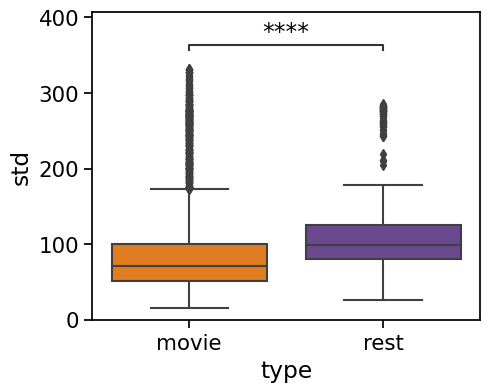

In [12]:
from statannotations.Annotator import Annotator

# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plotting_parameters = {
    'data':    df,
    'x':       'type',
    'y':       'std',
    'palette': sns.color_palette([sns.color_palette("bright")[1], sns.color_palette("Paired")[9]]),
    
}
# unpaired t-test
pvalues = [stats.ttest_ind(out_movie, out_rest).pvalue]
pairs = [('movie', 'rest')]
with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()
    # Plot with seaborn
    sns.boxplot(**plotting_parameters)
    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    plt.show()

#### Plot Visualization of variation circles

In [16]:
movie_grads = np.asarray([np.asarray(list(all_grads[mname].values()))
               for mname in total_series if mname != 'Rest'])
rest_grads = np.asarray(list(all_grads['Rest'].values()))

movie_parcelstd = np.asarray([np.asarray(list(all_dists[mname].values()))
               for mname in total_series if mname != 'Rest'])
rest_parcelstd = np.asarray(list(all_dists['Rest'].values()))

In [17]:
cf_circlemovie = movie_parcelstd.std(axis=1).mean(axis=0)
cf_circlerest = rest_parcelstd.std(axis=0)

perc = 99.5 # percentile removal
# print outliers indexes and their respetive regions
print('rest outliers: {}'.format([region2index[idx] for idx in np.where(cf_circlerest >= np.percentile(cf_circlerest, perc))[0]]))
print('movie outliers: {}'.format([region2index[idx] for idx in np.where(cf_circlemovie >= np.percentile(cf_circlemovie, perc))[0]]))
print('rest outliers idx: {}'.format(np.where(cf_circlerest >= np.percentile(cf_circlerest, perc))[0]))
print('movie outliers idx: {}'.format(np.where(cf_circlemovie >= np.percentile(cf_circlemovie, perc))[0]))

# remove outliers
cf_circlemovie[cf_circlemovie >= np.percentile(cf_circlemovie, perc)] = 0
cf_circlerest[cf_circlerest >= np.percentile(cf_circlerest, perc)] = 0

# normalize for movie max
norming = cf_circlemovie.max()
cf_circlemovie /= norming
cf_circlerest /= norming

# rescale for some arbitrary value to visualize properly
R = 1
cf_circlemovie *= R
cf_circlerest *= R

rest outliers: ['Vis', 'Cont', 'Sub']
movie outliers: ['SomMot', 'SomMot', 'Cont']
rest outliers idx: [  4 357 401]
movie outliers idx: [ 67 259 357]


In [18]:
_,ref_movie,n = procrustes_align(np.concatenate(movie_grads))
_,ref_rest,n = procrustes_align(rest_grads)

# align both reference gradients
refs,_,_ = procrustes_align([ref_movie, ref_rest])

cf_circles = [cf_circlemovie, cf_circlerest]

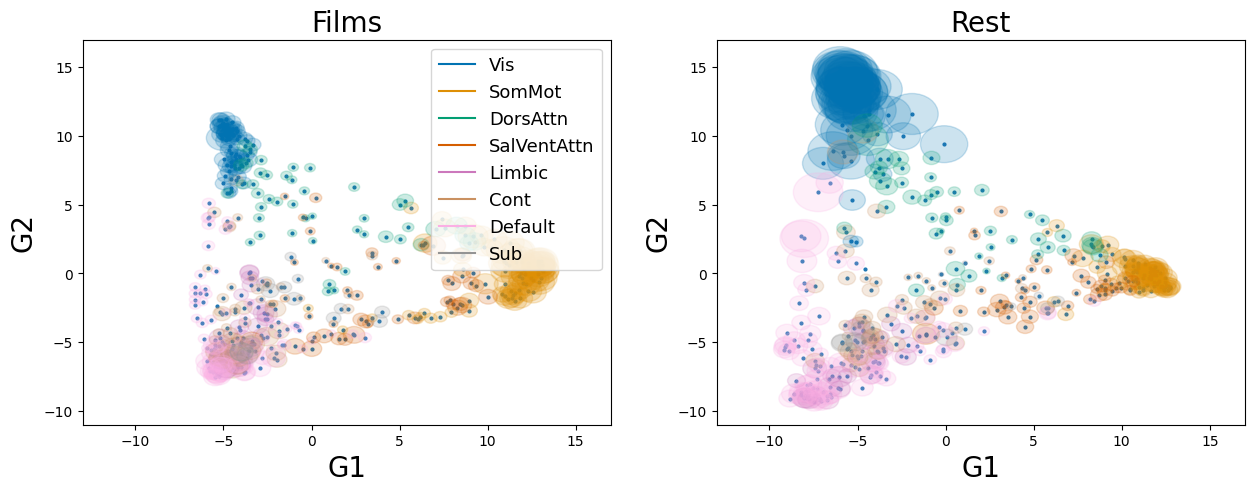

In [19]:
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
# pal     = sns.color_palette('cubehelix', len(index2region17))
pal     = sns.color_palette('colorblind', len(index2region))
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region414yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}

fig, axes = plt.subplots(1,2, figsize=(15,5))
plot_labels = ['Films', 'Rest']
for k in range(len(refs)):

    ref = refs[k]
    axes[k].scatter(ref[:,0], ref[:,1], s=4)
    circle_confusion = cf_circles[k]
    
    for i in range(len(circle_confusion)):
        c = partial_region[i]
        r = circle_confusion[i]
        cc = plt.Circle((ref[i][0],ref[i][1]), r ,alpha=0.2, color=colors[c])
        axes[k].add_artist(cc)
        
#         ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
#                             facecolor=colors[c], alpha=0.2)        
#         axes[row,col].add_patch(ellipse)

    axes[k].set_title("{}".format(plot_labels[k]), size=20)

    CN      = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[k].plot([], [], ls='-', c=c)[0] for c in CN]
    if k == 0:
        axes[k].legend(dummies, labels, loc=1, prop={'size':13})
    axes[k].set_xlim(-13,17)
    axes[k].set_ylim(-11,17)
    
    axes[k].set_xlabel('G1', fontsize=20)
    axes[k].set_ylabel('G2', fontsize=20)

plt.show()

#### ANOVA + Visualization of variation per network

In [20]:
cf_circlemovie = movie_parcelstd.std(axis=1)
cf_circlerest = rest_parcelstd.std(axis=0)

# remove outliers
perc = 99.5 # percentile removal
cf_circlemovie[cf_circlemovie >= np.percentile(cf_circlemovie.flatten(), perc)] = 0
cf_circlerest[cf_circlerest >= np.percentile(cf_circlerest, perc)] = 0

In [21]:
# Performing two-way ANOVA
networks = list(index2region)

df = {"score": [], "cond": [], 'network': []}
for n in networks:

    # adding movies
    for nb_movie in range(cf_circlemovie.shape[0]):
        df['score'] += list(cf_circlemovie[nb_movie][index2region[n]])
        df['cond']  += ['films'] * len(index2region[n])
        df['network'] += [n] * len(index2region[n])
        

    # adding rest
    df['score'] += list(cf_circlerest[index2region[n]])
    df['cond']  += ['rest'] * len(index2region[n])
    df['network'] += [n] * len(index2region[n])
    
df = pd.DataFrame.from_dict(df)


model = ols('score ~ C(cond) + C(network) + C(cond):C(network)',data=df).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(np.round(result,2).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      df &       sum\_sq &    mean\_sq &       F &  PR(>F) \\
\midrule
C(cond)            &     1.0 &    309197.21 &  309197.21 &  115.44 &     0.0 \\
C(network)         &     7.0 &   2926086.03 &  418012.29 &  156.07 &     0.0 \\
C(cond):C(network) &     7.0 &   1191371.84 &  170195.98 &   63.55 &     0.0 \\
Residual           &  6194.0 &  16589696.69 &    2678.35 &     NaN &     NaN \\
\bottomrule
\end{tabular}



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SomMot_films vs. SomMot_rest: Custom statistical test, P_val:5.447e-04
Vis_films vs. Vis_rest: Custom statistical test, P_val:1.441e-209
DorsAttn_films vs. DorsAttn_rest: Custom statistical test, P_val:1.130e-03
Default_films vs. Default_rest: Custom statistical test, P_val:3.456e-07


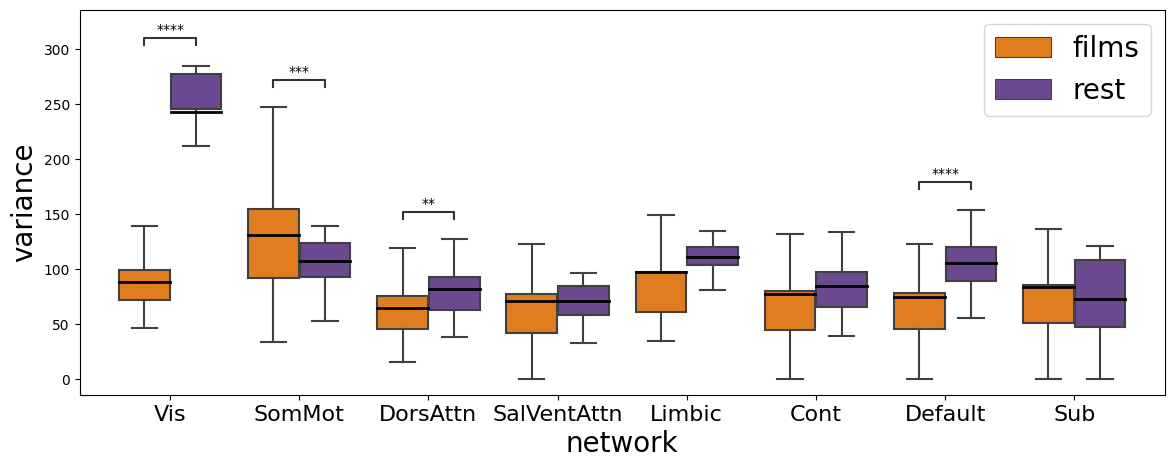

In [29]:
plt.figure(figsize=(14,5))

# plot the mean line
p = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            zorder=10,
            x="network",
            y="score", hue="cond",
            data=df,
            showfliers=False,palette=sns.color_palette([sns.color_palette("bright")[1], 
                                                        sns.color_palette("Paired")[9]]))

plotting_parameters = { 'data':    df,'x':'network',
                       'y':'score','hue':'cond','palette': sns.color_palette([
                           sns.color_palette("bright")[1], 
                       sns.color_palette("Paired")[9]])}

# paired t-test
pvalues = []
pairs = []
for net in networks:
    tmp = df[df['network'] == net]
    arr1 = np.nan_to_num(list(tmp[tmp['cond']=='films']['score']))
    arr2 = np.nan_to_num(list(tmp[tmp['cond']=='rest']['score']))
    pval = stats.ttest_ind(arr1, arr2).pvalue
    if pval > 0.05:
        continue
    pvalues.append(pval)
    pairs.append(((net,'films'), (net, 'rest')))
    
annotator = Annotator(p, pairs, **plotting_parameters)
annotator.set_pvalues(pvalues)
annotator.annotate()

plt.legend(prop={'size':20})
plt.ylabel('variance', fontsize=20)
plt.xlabel('network', fontsize=20)
plt.xticks(fontsize=16)
# plt.title("Fold repetition distribution of prediction correlations with personality indexes")
plt.show()